# Wikipedia Network Analysis - Short Tutorial

Brian Keegan, Ph.D. - March 18, 2016 -- Jupyter Days 2016, Boston, MA, USA

Released under a [CC-BY-SA 3.0 License](https://creativecommons.org/licenses/by-sa/3.0/).

[Web](http://www.brianckeegan.com); [@bkeegan](https://twitter.com/bkeegan); [GitHub](github.com/brianckeegan/)

The purpose of this tutorial is to introduce you to the basics of:

1. Extracting data from an public API
2. Converting these data into a tabular (spreadsheet-like) format
3. Creating a complex network out of these data
4. Analyzing the properties of the network

Obvious candidates for analyzing networks are social media platforms like Facebook or Twitter, but these require some distractions like registering for an API key. Instead, we are going to focus on extracting data from Wikipedia's free, public, and very powerful API. In particular, we are going to examine at least three kinds of networks that we can extract from Wikipedia data.

1. Hyperlink networks: how are articles linked to other articles?
2. Coauthorship networks: who edits which articles?
3. Contribution transition networks: who modifies whose revisions?

This version of the tutorial differs from [an earlier version](https://github.com/brianckeegan/Wikipedia-Network-Analysis/blob/master/Wikipedia%20Network%20Analysis.ipynb) as it incorporates changes made to the functionality of several of the libraries. It also focuses less on changes over time and more about extracting different kinds of networks.

# Import libraries

You will need the [`python-wikitools`](https://github.com/alexz-enwp/wikitools) library before we can proceed. This library is a wrapper that lets us talk to the Wikipedia API without having to write a bunch of code to handle the requests and such.

If you using a package manager like Anaconda or Enthought, you should be able to install from the command line by typing:

Import the libraries we'll be using throughout.

In [1]:
# Standard packages for data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

# numpy lets us handle numeric arrays efficiently
import numpy as np

# pandas handles tabular data
import pandas as pd

# These libraries let us get data from the web
import urllib2

# networkx handles network data
import networkx as nx

# To run queries against MediaWiki APIs
import wikitools as wt

# json handles reading and writing JSON data
import json

# To visualize webpages within this webpage
from IPython.display import HTML

# To parse links out of HTML markup in Wikipedia pages
from bs4 import BeautifulSoup

# Some other helper functions
from collections import Counter
from operator import itemgetter

C:\Users\bkeegan\AppData\Local\Continuum\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Write a basic query against the Wikipedia API

### A test query in the browser

We are going to make a query using the `list=users` action. [This page](http://en.wikipedia.org/w/api.php) contains all the documentation for the different queries you can run from Wikipedia's MediaWiki API. For our first test query, we'll want to get the information about a single user. Search for "list=users". You can also find similar information about this specific query action [here](https://www.mediawiki.org/wiki/API:Users) in the general MediaWiki documentation.

We can actually write a test query in the URL which will return results if the parameters are all valid. Use the example given on the `api.php` page of documentation:

http://en.wikipedia.org/w/api.php?action=query&list=users&ususers=Madcoverboy|Jimbo_Wales&usprop=blockinfo|groups|editcount|registration|gender

There are four parameters in this API call, separated by `&` signs:

* **`action`** - We pass a `query` option here to differentiate it from other actions we can run on the API like `parse`. But `action=query` will be what we use much of the time.
* **`list`** - This is one of several parameters we can use to make a query; search for "action=query" for others besides `list`. We pass a `users` option to `list` because we want to generate information about users. This lets us run the sub-options detailed in the documentation below.
* **`ususers`** - Here we list the names of Wikipedia users we want to get information about. We can pass more than one name by adding a pipe "`|`" between names. The documentation says we can only pass up to 50 names per request. Here we pass two names `Madcoverboy` for yours truly and `Jimbo_Wales` for the founder of Wikipedia.
* **`usprop`** - Here we pass a list of options detailed under the `list=users` about information we can obtain about any user. Again we use pipes to connect multiple options together. We are going to get information about whether a user is currently blocked (`blockinfo`), what powers the user has (`groups`), their total number of edits (`editcount`), the date and time they registered their account (`registration`), and their self-reported gender (`gender`).
* **format** - Here we list how we want the data to be formatted when it's returned to us. If you're a masochist and like parsing XML, that's the default. But we'll ask the API to give us JSON back since that's much more humane. The `format=jsonfm` I use in the code block immediately below is only to ask the API to give us prettily-formatted JSON rather than a concise but hard to read string. Change it to `format=json` to see what happens.

In summary, this API request is going to perform a query action that expects us to pass a list of user names and will return information about the users. We have given the query the names of the users we want information about as well as the specific types of information about each of these users.

The codeblock below shows what clicking the URL should return.

In [2]:
HTML('http://en.wikipedia.org/w/api.php?action=query&list=users&ususers=Madcoverboy|Jimbo_Wales&usprop=blockinfo|groups|editcount|registration|gender&format=jsonfm')

There's a lot of padding and fields from the JSON markup this returns by default, but the data are all in there. My `userid` is "304994", my `username` is "Madcoverboy" (which we already knew), I have 12,348 edts, I registered my account on June 21, 2005 at 1:52:16pm GMT, I identify as male, and I'm a member of four "groups" corresponding to my editing privileges: `reviewer`, `*`, `user`, and `autoconfirmed`.

### Running the same query in Python

Clicking on the link will run the query and return the results in your web browser. However, the point of using an API is not for you to make queries with a URL and then copy-paste the results into Python. We're going to run the query within Python (rather than the web browser) and return the data back to us in a format that we can continue to use for analysis.

We can use some basic Python libraries to return the same data in a more usable way. Using a similar query as above (note that I changed to the `format=json`) we can define a request, make it and receive a response, read in the data it returned, convert it to something useful like a dictionary, and finally inspect it.

In [3]:
# Write out the same request
s = 'http://en.wikipedia.org/w/api.php?action=query&list=users&ususers=Madcoverboy|Jimbo_Wales&usprop=blockinfo|groups|editcount|registration|gender&format=json'

# Define all the onerous calls and functions
request = urllib2.Request(s)
response = urllib2.urlopen(request)

#  Get the data
data_string = response.read()

# Convert it to something more useful than a string
data = json.loads(data_string)

# Inspect it!
data

{u'batchcomplete': u'',
 u'query': {u'users': [{u'editcount': 12361,
    u'gender': u'male',
    u'groups': [u'reviewer', u'*', u'user', u'autoconfirmed'],
    u'name': u'Madcoverboy',
    u'registration': u'2005-06-21T13:52:16Z',
    u'userid': 304994},
   {u'editcount': 12624,
    u'gender': u'unknown',
    u'groups': [u'checkuser',
     u'founder',
     u'oversight',
     u'sysop',
     u'*',
     u'user',
     u'autoconfirmed'],
    u'name': u'Jimbo Wales',
    u'registration': u'2001-03-27T20:47:31Z',
    u'userid': 24}]}}

There's a lot that can go wrong with trying to write our own functions to talk to the API, so it's best to rely on existing libraries that accomplish the same thing rather than trying to reinvent the wheel. In this case, we'll use the wikitools library's `query` to handle all the requests and formatting.

First we need to write a basic function [1] that will accept something that corresponds to the query we want to run, goes out and connects to the English Wikipedia's MediaWiki API "spigot", formats our query for this API to understand, runs the query until all the results come back, and then returns the results to us as some data object. The function below does all of those things, but it's best to just treat it as a black box for now that accepts queries and spits out the results from the English Wikipedia. 

(If you want to use another another MediaWiki API, replace the current URL following `site_url` with the corresponding API location. For example, [Memory Alpha](http://en.memory-alpha.org/)'s is http://en.memory-alpha.org/api.php)

[1] We won't end up using the basic function later on since it behaves badly under some important conditions.

In [4]:
def basic_wikipedia_query(query_params,site_url='http://en.wikipedia.org/w/api.php'):
    # What site will we connect to? Defaults to English Wikipedia (above)
    site = wt.wiki.Wiki(url=site_url) 
    
    # Prepare the query request
    request = wt.api.APIRequest(site, query_params) 
    
    # Make the query
    result = request.queryGen() 
    
    # This is a bit of a hack that will break things in a bit
    result_list = list(result)[0]
    
    # Return the results    
    return result_list[query_params['action']] 

We can write the exact same query as we used above using a dictionary for all the same request parameters as key value pairs and save the dictionary as `user_query`. For example, where we used `action=query` in the URL above, we use `'action':'query'` as a key-value pair of strings (make sure to include the quotes marking these as strings, rather than variables!) in the query dictionary. Then we can pass this query dictionary to the `wikipedia_query` black box function defined above to get the exact same information out. We save the output in `query_results` and can look at the results by calling this variable.

In [5]:
user_query = {'action':'query',
              'list':'users',
              'usprop':'blockinfo|groups|editcount|registration|gender',
              'ususers':'Madcoverboy|Jimbo Wales'}

query_results = basic_wikipedia_query(user_query)
query_results

{u'users': [{u'editcount': 12361,
   u'gender': u'male',
   u'groups': [u'reviewer', u'*', u'user', u'autoconfirmed'],
   u'name': u'Madcoverboy',
   u'registration': u'2005-06-21T13:52:16Z',
   u'userid': 304994},
  {u'editcount': 12624,
   u'gender': u'unknown',
   u'groups': [u'checkuser',
    u'founder',
    u'oversight',
    u'sysop',
    u'*',
    u'user',
    u'autoconfirmed'],
   u'name': u'Jimbo Wales',
   u'registration': u'2001-03-27T20:47:31Z',
   u'userid': 24}]}

The data structure that is returned is a dictionary keyed by `'users'` which returns a list of dictionaries. Knowing that the data corresponding to `Jimbo Wales` is the second element in the list of dictionaries (remember Python indices start at 0, so the 2nd element corresponds to 1), we can access his edit count. 

In [6]:
query_results['users'][1]['editcount']

12624

Since the first document in the user list corresponds to my activity, we can identify how many edits I've made as well for comparison.

In [7]:
query_results['users'][0]['editcount']

12361

The `query_results` data has two "observations" corresponding to "Madcoverboy" and "Jimbo Wales". We could create a CSV with the columns corresponding to the field names (`editcount`, `gender`, `groups`, `name`, `registration`, `userid`) and then two rows containing the corresponding values for each user.

Using a powerful library called "[pandas](http://pandas.pydata.org/)" (short for "panel data", not the [cute bears](https://inhistime.files.wordpress.com/2010/10/cute-panda.jpg)), we can pass the list of data inside `query_results` and pandas will attempt to convert it to a tabular format called a DataFrame that can be exported to CSV. We save this as `df` and then use the `to_csv` function to write this DataFrame to a CSV file. We use to extra options, declaring quotation marks to make sure the data in `groups`, which already contains commas, doesn't get split up later. We don't care about the row numbers (the index), so we declare `index=False` so they aren't exported.

In [8]:
query_results_df = pd.DataFrame(query_results['users'])
#query_results_df.to_csv('query_results.csv',quotechar='"',index=False)
query_results_df

,editcount,gender,groups,name,registration,userid
0,12361,male,"[reviewer, *, user, autoconfirmed]",Madcoverboy,2005-06-21T13:52:16Z,304994
1,12624,unknown,"[checkuser, founder, oversight, sysop, *, user...",Jimbo Wales,2001-03-27T20:47:31Z,24


In this section, we've covered the basics for how:

* to look up documentation about the MediaWiki API
* format a basic query and test to make sure it works within a web browser
* running the same query within Python
* writing a function to simplify querying data
* writing the results of these queries to files so we can access these data later.

In the next sections, we'll use other queries to get more interesting data about relationships and more advanced data manipulation techniques to prepare these data for social network analysis.

# Create a hyperlink network

### Goal

The value of Wikipedia articles (or really the web in general) is the fact that individual articles (pages) link to each other. We are going to use the Wikipedia article for the presumptive Democratic presidential candidate "[Hillary Rodham Clinton](https://en.wikipedia.org/wiki/Hillary_Rodham_Clinton)" as an example.

In [8]:
HTML('<iframe src=https://en.wikipedia.org/w/index.php?title=Hillary_Clinton&useformat=mobile width=700 height=350></iframe>')

### Approach

We need a few helper functions to simplify the output of the queries that Wikipedia will return. First, we write an `extract_to_list` function to conver the JSON-like nested results returned by the API and convert it into a more useful list of the content we care about.

In [9]:
def extract_query_to_list(json, stuff, key):
    l = []
    pageid = str(json['query']['pages'].keys()[0])
    if stuff in json['query']['pages'][pageid]:
        for item in json['query']['pages'][pageid][stuff]:
            if key:
                l.append(item[key])
            else:
                l.append(item)
    return l

We're going to write a new qury function that takes advantage of some of the more advanced features of the wikitools library to handle some of the limitations of the API (paging of query results, etc.)

In [10]:
def wikipedia_query(wiki,params,stuff,key):
    """ Perform a query on a 'wiki' endpoint, with a dictionary of parameters, that returns results keyed by 'stuff'
    """
    # Make the query
    results = wt.api.APIRequest(wiki=wiki,data=params).queryGen()
    
    # The results are a generator, so we need to catch the data
    result_list = []
    for result in results:
        result_list += extract_query_to_list(result,stuff,key)
        
    return result_list

### List of articles linked from an article

We are going to use the `prop=links` query to identify a list of articles that are *currently* linked *from* an article. The general MediaWiki documentation for this query is [here](https://www.mediawiki.org/wiki/API:Properties#links_.2F_pl). We will specify a query using the `action=query` to define a general class of query, the `prop=links` to indicate we want the current links from a page, and then pass the name of a page with `titles=Hillary Rodham Clinton`.

There are [many "namespaces" of Wikipedia pages](https://en.wikipedia.org/wiki/Wikipedia:Namespace) that reflect different kinds of pages for articles, article talk pages, user pages, user talk pages, and other administrative pages. Links to and from a Wikipedia article can come from all these name spaces, but because the Wikipedia articles that 99% of us ever read are located inside the "0" namespace, we'll only want to limit ourselves to links in that namespace rather than these "backchannel" links. We enforce this limit with the `plnamespace=0` option.

There could potentially be hudreds of links from a single article but the API will only return some number per request. The `wikitools` library takes care of automatically generating additional requests if there is more data to obtain after the first request. Ideally, we could specify a large number like 10,000 to make sure we get all the links with a single request, but the API enforces a limit of 500 links per request and defaults to only 10 per request. We use the `pllimit=500` to make sure we get the maximum number of links per request instead of issuing 50 requests.

In [11]:
hc_outlink_params = {'action': 'query',
                 'prop': 'links',
                 'titles': 'Hillary Clinton',
                 'pllimit': '500',
                 'plnamespace':'0'}

# Create a Wiki object that points to the English Wikipedia API endpoint
enwp = wt.wiki.Wiki(url='https://en.wikipedia.org/w/api.php')

In [12]:
hc_outlink_data = wikipedia_query(enwp,hc_outlink_params,'links','title')
print "There are {0} links in the Hillary Clinton article.".format(len(hc_outlink_data))
hc_outlink_data[:10] # Show first 103

There are 1575 links in the Hillary Clinton article.


[u'1968 Republican National Convention',
 u'1992 Democratic National Convention',
 u'1994 State of the Union Address',
 u'1995 State of the Union Address',
 u'1996 Democratic National Convention',
 u'1996 State of the Union Address',
 u'1997 State of the Union Address',
 u'1998 State of the Union Address',
 u'1999 State of the Union Address',
 u'2000 State of the Union Address']

##### A note on redirects

Note that there is an article for "Hillary Rodham Clinton" as well, but this article is a [redirect](https://en.wikipedia.org/wiki/Wikipedia:Redirect). In other words, this article exists and has data that can be accessed from the API, but it's suspiciously sparse and just points to "Hillary Clinton".

In [13]:
hrc_outlink_params = {'action': 'query',
                    'prop': 'links',
                    'titles': 'Hillary Rodham Clinton',
                    'pllimit': '500',
                    'plnamespace': '0'}

hrc_outlink_data = wikipedia_query(enwp,hrc_outlink_params,'links','title')
print "There are {0} links in the Hillary Rodham Clinton article.".format(len(hrc_outlink_data))
hrc_outlink_data

There are 1 links in the Hillary Rodham Clinton article.


[u'Hillary Clinton']

The MediaWiki API has a `redirects` option that lets us ignore these placeholder redirect pages and will follow the redirect to take us to the intended page. Adding this option to the query but specifying the same `Hillary Clinton` value for the `titles` parameter that previously led to a redirect now returns all the data at the "Hillary Rodham Clinton" article. We'll make sure to use this `redirects` option in future queries.

In [14]:
hrc_outlink_params_redirect = {'action': 'query',
                             'prop': 'links',
                             'titles': 'Hillary Rodham Clinton', # still "Hillary Rodham Clinton"
                             'pllimit': '500',
                             'plnamespace': '0',
                             'redirects': 'True'} # redirects parameter added

hrc_redirect_outlink_data = wikipedia_query(enwp,hrc_outlink_params_redirect,'links','title')
print "There are {0} links from the Hillary Clinton article (via Hillary Rodham Clinton)".format(len(hrc_redirect_outlink_data))
hrc_redirect_outlink_data[:10]

There are 1575 links from the Hillary Clinton article (via Hillary Rodham Clinton)


[u'1968 Republican National Convention',
 u'1992 Democratic National Convention',
 u'1994 State of the Union Address',
 u'1995 State of the Union Address',
 u'1996 Democratic National Convention',
 u'1996 State of the Union Address',
 u'1997 State of the Union Address',
 u'1998 State of the Union Address',
 u'1999 State of the Union Address',
 u'2000 State of the Union Address']

### List of articles linking to an article

We are going to use the `prop=linkshere` query to identify a list of articles that *currently* link to the Hillary Rodham Clinton article. The parameters for this query are a bit different. We still use a namespace limitation so we are only getting pages in the article namespace by specifying `lhnamespace=0` and we want to maximize the number of links per query that the API allows by specifying `lhlimit=500`. However, we don't want to include redirects that point to this article (e.g., "Hillary Clinton" points to "Hillary Rodham Clinton") by specifying `lhshow=!redirect`. Finally we only want the names of the articles, rather than less important information like "pageid" or "redirects", so we can limit this by specifying `lhprop=title`.

In [15]:
hc_inlink_query = {'action': 'query',
                    'redirects': 'True',
                    'prop': 'linkshere',
                    'titles': 'Hillary Clinton',
                    'lhlimit': '500',
                    'lhnamespace': '0',
                    'lhshow': '!redirect',
                    'lhprop': 'title'}

hc_inlink_data = wikipedia_query(enwp,hc_inlink_query,'linkshere','title')
print "There are {0} links to the Hillary Clinton article".format(len(hc_inlink_data))
hc_inlink_data[:10]

There are 3937 links to the Hillary Clinton article


[u'Arizona State University',
 u'Austin, Texas',
 u'Agent Orange',
 u'Aung San Suu Kyi',
 u'The Bronx',
 u'Bill Clinton',
 u'Bankruptcy',
 u'Chicago Cubs',
 u'Colin Powell',
 u'Cook Islands']

# Make a basic ego-network

Having collected data about the neighboring articles that are linked to or from one article, we can turn these data into an ego network. Using the `NetworkX` library (shortened to `nx` on import at the top), we will create a `DiGraph` object called `hc_g` and then fill it with the connection data we just collected. We do this by iterating over the lists of links (`hrc_inlink_data` and `hrc_outlink_data`) and adding a directed edge between each neighbor and the original article. It's important to pay attention to edge direction as the out-links should start at "Hillary Clinton" and end at the neighboring article whereas the in-links should start at the neighboring article and end at "Hillary Clinton".

In [16]:
hc_g = nx.DiGraph()

for outlinked_article in hc_outlink_data:
    hc_g.add_edge('Hillary Clinton',outlinked_article)
    
for inlinked_article in hc_inlink_data:
    hc_g.add_edge(inlinked_article,'Hillary Clinton')

Do some basic statistics on the graph.

In [17]:
print "There are {0} nodes in the network.".format(hc_g.number_of_nodes())
print "There are {0} edges in the network.".format(hc_g.number_of_edges())

There are 4593 nodes in the network.
There are 5511 edges in the network.


Inspect the `hc_g` object. These are all the articles that link from and to the Hillary Clinton article.

In [18]:
hc_g.nodes()[:10]

[u'John Kasich presidential campaign, 2016',
 u'Violet Hill',
 u'Yucaipa Companies',
 u'Lindsey Graham presidential campaign, 2016',
 u'The First Lady (Faith Evans album)',
 u'Fuerzas Armadas de Liberaci\xf3n Nacional Puertorrique\xf1a',
 u'Governor of Arkansas',
 u'Mark Penn',
 u'Impeachment and acquittal of Bill Clinton',
 u'Markos Moulitsas']

Find reciprocated hyperlinks, where A links to B and B links to A. These would suggest both articles agree that there's a strong relationship between the topics.

In [19]:
reciprocal_edges = list()
for (i,j) in hc_g.edges():
    if hc_g.has_edge(j,i) and (j,i) not in reciprocal_edges:
        reciprocal_edges.append((i,j))
        
reciprocation_fraction = round(float(len(reciprocal_edges))/hc_g.number_of_edges(),3)
print "There are {0} reciprocated edges out of {1} edges in the network, giving a reciprocation fraction of {2:.1%}.".format(len(reciprocal_edges),hc_g.number_of_edges(),reciprocation_fraction)

There are 919 reciprocated edges out of 5511 edges in the network, giving a reciprocation fraction of 16.7%.


In [20]:
reciprocated_articles = []

for (article1,article2) in hc_g.edges_iter():
    # Check if the swapped edge exists
    if hc_g.has_edge(article2,article1): 
        # If it does, check if the first article is Hillary Clinton
        if article1 != "Hillary Clinton":
            # If it's not Hillary Clinton, add it to the article
            reciprocated_articles.append(article1)
        else:
            # Otherwise, add the other article to the list
            reciprocated_articles.append(article2)
        
print "There are {0} reciprocated articles in the network.".format(len(set(reciprocated_articles)))
reciprocated_articles[:10]

There are 919 reciprocated articles in the network.


[u'John Kasich presidential campaign, 2016',
 u'Lindsey Graham presidential campaign, 2016',
 u'Julie Krone',
 u'War Powers Resolution',
 u'Susan Estrich',
 u'Emily Dickinson',
 u'Libertarian Party presidential primaries, 2016',
 u'Thomas C. Platt',
 u'Ralph Nader presidential campaign, 2008',
 u'Emily Howell Warner']

### Historical hyperlinks

The queries above only looked at the links coming from the *current* version of the article. However Wikipedia archives every version of the article, so we can rewind the tape all the way back to the first version of Hillary's article back in 2001, a few months after Wikipedia was created. Specific versions of a Wikipedia article are identified with a `revid`, which is also called an `oldid` in some contexts. In subsequent sections, we'll go into more detail on how to get a list of all revisions to an article and find the oldest revision. But for the time being, just trust me that `revid` "256189" is the oldest (a.k.a, first) version of the Hillary Rodham Clinton article. Take a peek at what the article looked like back then below:

In [128]:
HTML('<iframe src=https://en.wikipedia.org/w/index.php?title=Hillary_Rodham_Clinton&oldid=256189&useformat=mobile width=700 height=350></iframe>')

We can write a new set of data extraction functions. The first, `extract_parse_to_list` is analogous to the `extract_query_to_list` from before, but accounts for the difference in the returned data structure. The second, `wikipedia_parse` is also analogous to the `wikipedia_query` function from before and take advantage of the `extract_parse_to_list` function.

In [21]:
def extract_parse_to_list(json, stuff,key):
    l = []
    if stuff in json['parse'].keys():
        for item in json['parse'][stuff]:
            l.append(item[key])
    return l

def wikipedia_parse(wiki,params,stuff,key):
    """ Perform a query on a 'wiki' endpoint, with a dictionary of parameters, that returns results keyed by 'stuff'
    """
    # Make the query
    results = wt.api.APIRequest(wiki=wiki,data=params).queryGen()
    
    # The results are a generator, so we need to catch the data
    result_list = []
    for result in results:
        result_list += extract_parse_to_list(result,stuff,key)
        
    return result_list

Define a set of parse parameters `oldest_outlinks_query_hc` to extract from the API. Use the `wikipedia_parse` function to get the list of articles linked from this oldest version of the article.

In [22]:
oldest_outlinks_query_hc = {'action': 'parse', #query changes to parse
                             'prop': 'links',
                             'oldid': '256189'}

hc_oldest_outlinks = wikipedia_parse(enwp,oldest_outlinks_query_hc,'links','*')
print "There are {0} outlinks in oldest revision of the Hillary Clinton article.".format(len(hc_oldest_outlinks))
hc_oldest_outlinks[:10]

There are 9 outlinks in oldest revision of the Hillary Clinton article.


[u'Baby Boom',
 u'Bill Clinton',
 u'First Lady',
 u'New York',
 u'October 26',
 u'Senators Of The United States',
 u'United States/President',
 u'United States Senate',
 u'Watergate']

So now we can also extract links from historical versions of the article. However, it's *much* more difficult to get the history of what links in to an article (e.g., `linkshere`) as this would require potentially looking at the history of every other article to check if a link was ever made from that article to another article. This is not impossible, just very *very* time-consuming.

### Summary

In this section we learned to write and combine queries to get us the links to and from the current version of an article, how to handle redirects between articles, use these lists of links to make a network object, and did some preliminary analysis of an article's ego network. There are some limitations on the specificity of the links that the API passes back which limits our ability to generate more complex networks using this query. 

We also showed that it's possible to get the out links from a historical version of an article using a new kind of API action called a `parse`. Using the out links from all the changes to an article could let us look at the evolution of what the article linked to over time. We'll go into how to get all the changes to an article in the next section.

# Complete article history

The previous section showed how to make a basic network from the current hyperlinks to and from a Wikipedia article. It also alluded to the fact that Wikipedia captures the history of every change made to the article since it was created as well as who made these changes and when (among other meta-data). In this section, we'll explore some queries around how to extract the "revision history" of an article from the API. We'll do some exploratory analysis using these data to understand patterns in the distribution of editors' activity, changes in content, and the persistence of revisions. Additionally, we'll construct a co-authorship network of what editors made a change to the article.

Starting with a basic query, we'll get every change that's been made to the "Hillary Clinton" article. We'll use `action=query` and `prop=revisions` to get the list of changes to an article (see detailed documentation [here](https://www.mediawiki.org/wiki/API:Properties#revisions_.2F_rv)). There are many options to specify here. We pass several options to `rvprop` to get the revision ids, timestamp, user, user ID, revision comment, and the size of the article; "max" to `rvlimit` to get all the revisions; "newer" to `rvdir` so the revisions come back in chronological order (oldest to newest). There are many other options that can be specified such as `rvprop=content` to get the content of each revision or `rvstart` and `rvend` to get revisions within a specific timeframe, and `rvexcludeuser` to omit changes from bots for example.

In [23]:
revisions_query_hc = {'action': 'query',
                      'redirects': 'True',
                      'prop': 'revisions',
                      'titles': "Hillary Rodham Clinton",
                      'rvprop': 'ids|user|timestamp|userid|comment|size',
                      'rvlimit': '500',
                      'rvdir': 'newer'}

revisions_data_hc = wikipedia_query(enwp,revisions_query_hc,'revisions',None)
print "There have been a total of {0} revisions made to the article.".format(len(revisions_data_hc))
revisions_data_hc[0]

There have been a total of 13449 revisions made to the article.


{u'comment': u'*',
 u'parentid': 0,
 u'revid': 256189,
 u'size': 380,
 u'timestamp': u'2001-08-01T20:21:17Z',
 u'user': u'Koyaanis Qatsi',
 u'userid': 90}

Covert these data to a tabular format to make data analysis easier. pandas can interpret the list of dictionaries with a Datarame where each dictionary in the list is a row in the table and each key in each dictionary is a column in the table.

In [24]:
hc_revision_df = pd.DataFrame(revisions_data_hc)
hc_revision_df.head()

,anon,comment,parentid,revid,size,timestamp,user,userid
0,NaN,*,0,256189,380,2001-08-01T20:21:17Z,Koyaanis Qatsi,90
1,,*added a bit on Hillary Clinton,256189,256190,697,2001-12-07T01:58:07Z,152.163.197.xxx,0
2,NaN,Took out the slander,256190,256191,663,2001-12-07T02:14:20Z,Paul Drye,6
3,,Automated conversion,256191,72270,877,2002-02-25T15:51:15Z,Conversion script,0
4,,*,72270,72271,920,2002-05-18T16:37:57Z,210.49.193.178,0


Lets do some additional data cleanup.

In [25]:
# Make it clear what's being edited
hc_revision_df['page'] = 'Hillary Clinton'

# Clean up timestamps
hc_revision_df['timestamp'] = pd.to_datetime(hc_revision_df['timestamp'],format="%Y-%m-%dT%H:%M:%SZ",unit='s')

# Extract dates
hc_revision_df['date'] = hc_revision_df['timestamp'].apply(lambda x:x.date())

# Clean up anon column
hc_revision_df = hc_revision_df.replace({'anon':{np.nan:False,u'':True}})

# Sort the data on timestamp and reset the index
hc_revision_df = hc_revision_df.sort_values('timestamp').reset_index(drop=True)
hc_revision_df.index.name = 'revision'
hc_revision_df = hc_revision_df.reset_index()

# Set the index to a MultiIndex
hc_revision_df.set_index(['page','revision'],inplace=True)

# Save the data to disk
#hc_revision_df.to_csv('hc_revisions.csv',encoding='utf8')

# Show the first 5 rows
hc_revision_df.head()

anon                          comment  parentid  \
page            revision                                                     
Hillary Clinton 0         False                                *         0   
                1          True  *added a bit on Hillary Clinton    256189   
                2         False             Took out the slander    256190   
                3          True             Automated conversion    256191   
                4          True                                *     72270   

                           revid  size           timestamp               user  \
page            revision                                                        
Hillary Clinton 0         256189   380 2001-08-01 20:21:17     Koyaanis Qatsi   
                1         256190   697 2001-12-07 01:58:07    152.163.197.xxx   
                2         256191   663 2001-12-07 02:14:20          Paul Drye   
                3          72270   877 2002-02-25 15:51:15  Conversion script   
                4          72271   920 2002-05-18 16:37:57     210.49.193.178   

                          userid        date  
page            revision                      
Hillary Clinton 0             90  2001-08-01  
                1              0  2001-12-07  
                2              6  2001-12-07  
                3              0  2002-02-25  
                4              0  2002-05-18

### Revision activity

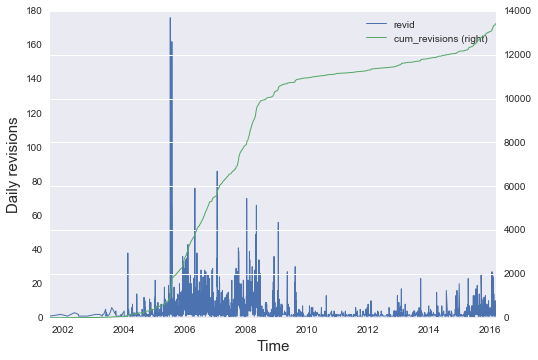

In [26]:
activity_by_day = hc_revision_df.groupby('date').aggregate({'revid':len})
activity_by_day['cum_revisions'] = activity_by_day['revid'].cumsum()

ax = activity_by_day.plot(lw=1,secondary_y=['cum_revisions'])
#patches, labels = ax.get_legend_handles_labels()
#ax.legend(patches, labels, loc='center left',bbox_to_anchor=(1,.5))

ax.set_ylabel('Daily revisions',fontsize=15)
ax.set_xlabel('Time',fontsize=15)

### User activity

We might be interested in looking at the most active editors over the history of the article. We can perform a `groupby` operation that effectively creates a mini-DataFrame for each user's revisions. We use the `aggregate` function to collection information (`len` gets us the number of revisions they made) across all these mini-DataFrames and returns a `Series` object with the username and the number of their revisions. Sorting these revisions is descending order and then look at the top-5 revisions, which exhibits variation over nearly two orders of magnitude.

In [27]:
hc_revision_gb_user = hc_revision_df.groupby('user')
hc_user_revisions = hc_revision_gb_user['revid'].aggregate(len).sort_values(ascending=False,inplace=False)
print "There are {0} unique users who have made a contribution to the article.".format(len(hc_user_revisions))
hc_user_revisions.head(10)

There are 3834 unique users who have made a contribution to the article.


user
Wasted Time R      2357
LukeTH              656
Tvoz                314
K157                137
Professor JR        123
Anythingyouwant     117
Mark Miller          83
StuffOfInterest      74
Scjessey             65
Ohnoitsjamie         57
Name: revid, dtype: int64

Given the wide variation among the number of contributions from users, we can create a kind of "histogram" that plots how many users made how many revisions. Because there is so much variation in the data, we use logged axes. In the upper left, there are several thousand editors who made only a single contribution. In the lower right, are the single editors listed above who made several hundred revisions to this article.

In [28]:
revisions_counter = hc_user_revisions.value_counts()
revisions_counter.head()

1    2368
2     627
3     293
4     167
5      76
Name: revid, dtype: int64

In [29]:
revisions_counter[revisions_counter == 1].sort_index().tail()

123     1
137     1
314     1
656     1
2357    1
Name: revid, dtype: int64

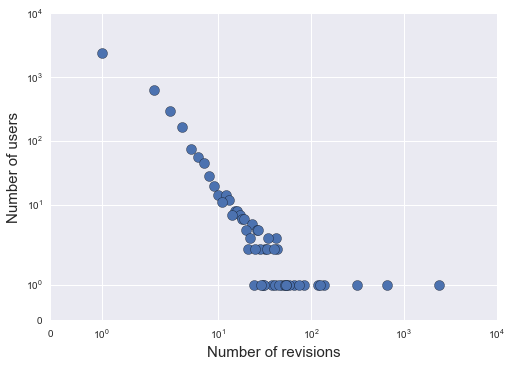

In [30]:
ax = revisions_counter.reset_index().plot(x='index',y='revid',kind='scatter',s=100)
ax.set_ylabel('Number of users',fontsize=15)
ax.set_xlabel('Number of revisions',fontsize=15)
ax.set_yscale('symlog')
ax.set_xscale('symlog')
ax.set_ylim((0,1e4))
ax.set_xlim((0,1e4));

### Revision changes

We can also look at the distribution in changes to the article's size. In other words, how much content (in bytes) was introduced or removed from the article by an editor's changes? We see there is a very wide (axes are still on log scales) and mostly symmetrical distribution in additions and removals of content. In other words, the most frequent changes are extremely minor (-1 to 1 bytes) and the biggest changes (dozens of kilobytes) are very rare --- and likely the result of vandalism and reversion of vandalism. Nevertheless it's the case that this Wikipedia article's history is as much about the *removal* of content as it is about the *addition* of content.

In [31]:
hc_revision_df['diff'] = hc_revision_df['size'].diff()
hc_revision_df['diff'].head()

page             revision
Hillary Clinton  0             NaN
                 1           317.0
                 2           -34.0
                 3           214.0
                 4            43.0
Name: diff, dtype: float64

There are 646 revisions that don't change the length of the article. The next largest group of revisions are small changes that result in only additions or removals of a single character.

In [32]:
diffs_counts = hc_revision_df['diff'].value_counts()
#diffs_counts = diffs_counts.apply(lambda x:round(x,-1)) # round off integers
diffs_counts.head()

 0.0    646
 1.0    342
-1.0    308
 4.0    253
 2.0    212
Name: diff, dtype: int64

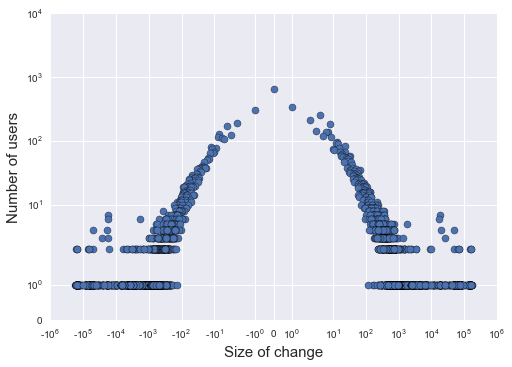

In [33]:
ax = diffs_counts.reset_index().plot(x='index',y='diff',kind='scatter',s=50)
ax.set_ylabel('Number of users',fontsize=15)
ax.set_xlabel('Size of change',fontsize=15)
ax.set_yscale('symlog')
ax.set_xscale('symlog')
ax.set_ylim((0,1e4))
ax.set_xlim((-1e6,1e6));

### Edit latencies

We can also explore how long an edit persists on the article before another edit is subsequently made. The average edit only persists for ~34,500 seconds (~9.5 hours) but the median edit only persists for 881 seconds (~15 minutes).

In [34]:
# The diff returns timedeltas, but dividing by a 1-second timedelta returns a float
# Round these numbers off to smooth out the distribution and add 1 second to everything to make the plot behave
hc_revision_df['latency'] = hc_revision_df['timestamp'].diff().apply(lambda x:round(x/np.timedelta64(1,'m'),0))
latency_counter = hc_revision_df['latency'].value_counts()
latency_counter.sort_values(ascending=False).head()

1.0    1724
2.0    1052
3.0     715
0.0     586
4.0     473
Name: latency, dtype: int64

In [35]:
hc_revision_df['latency'].describe()

count     13448.000000
mean        571.827707
std        3462.326969
min           0.000000
25%           2.750000
50%          17.000000
75%         247.000000
max      183217.000000
Name: latency, dtype: float64

(-1, 1000000.0)

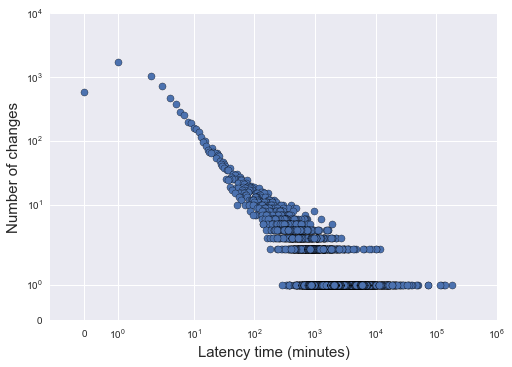

In [36]:
ax = latency_counter.reset_index().plot(x='index',y='latency',kind='scatter',s=50)
ax.set_xlabel('Latency time (minutes)',fontsize=15)
ax.set_ylabel('Number of changes',fontsize=15)
ax.set_yscale('symlog')
ax.set_xscale('symlog')
ax.set_ylim((0,1e4))
ax.set_xlim((-1,1e6))

As we did above, we can recompute `activity_by_day` to include daily median changes in the latency between edits. There is substantial variation in how long edits persist. Again, the pre-2006 era is marked by content that goes days or weeks without changes, but between 2006 and 2009 the time between edits becomes much shorter, presumably corresponding with the attention around her presidential campaign. After 2008, the time between changes increases again and stabilizes at its (smoothed) current value of around 2 days between edits.

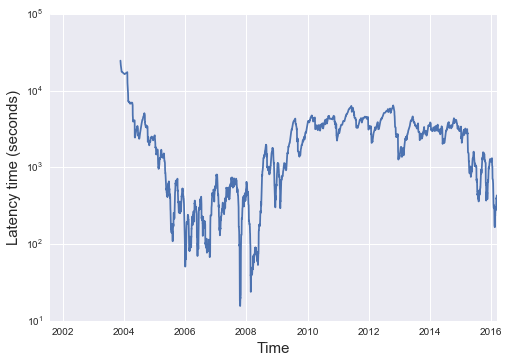

In [37]:
activity_by_day = hc_revision_df.groupby('date').aggregate({'revid':len,
                                                       'diff':np.median,
                                                       'latency':np.median})

# Compute a 28-day rolling average to remove spikiness, plot
activity_by_day['latency'].rolling(window=28).mean().plot()
plt.yscale('symlog')
plt.xlabel('Time',fontsize=15)
plt.ylabel('Latency time (seconds)',fontsize=15)

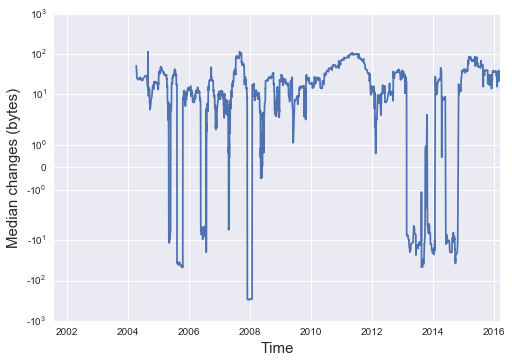

In [38]:
# Compute a 56-day rolling average to remove spikiness, plot
activity_by_day['diff'].rolling(window=56).mean().plot()
plt.yscale('symlog')
plt.xlabel('Time',fontsize=15)
plt.ylabel('Median changes (bytes)',fontsize=15)

# Network Analysis

In [39]:
candidates_2016_params = {'action': 'query',
                             'prop': 'links',
                             'titles': 'Template:United_States_presidential_election,_2016',
                             'pllimit': '500',
                             'plnamespace': '0',
                             'redirects': 'True'} # redirects parameter added

candidates_2016_articles = wikipedia_query(enwp,candidates_2016_params,'links','title')
print "There are {0} links from the 2016 US presidential election template".format(len(candidates_2016_articles))
candidates_2016_articles[:10]

There are 149 links from the 2016 US presidential election template


[u'2016 Democratic National Convention',
 u'2016 Green National Convention',
 u'2016 Libertarian National Convention',
 u'2016 Republican National Convention',
 u'Alyson Kennedy',
 u'Andy Martin',
 u'Angela Walker',
 u'Austin Petersen',
 u'Ben Carson',
 u'Ben Carson presidential campaign, 2016']

In [40]:
def get_revision_df(article):
    revisions_query = {'action': 'query',
                      'redirects': 'True',
                      'prop': 'revisions',
                      'titles': article,
                      'rvprop': 'ids|user|timestamp|user|userid|comment|size',
                      'rvlimit': '500',
                      'rvdir': 'newer'}

    revisions_data = wikipedia_query(enwp,revisions_query,'revisions',None)

    # Extract and convert to DataFrame. Try/except for links to pages that don't exist
    try:
        df = pd.DataFrame(revisions_data)
        
        # Make it clear what's being edited
        df['page'] = article

        # Clean up timestamps
        df['timestamp'] = pd.to_datetime(df['timestamp'],format="%Y-%m-%dT%H:%M:%SZ",unit='s')

        # Clean up anon column. If/else for articles that have all non-anon editors
        if 'anon' in df.columns:
            df = df.replace({'anon':{np.nan:False,u'':True}})
        else:
            df['anon'] = False

        # Sort the data on timestamp and reset the index
        df = df.sort_values('timestamp').reset_index(drop=True)
        df.index.name = 'revision'
        df = df.reset_index()

        # Set the index to a MultiIndex
        #df.set_index(['page','revision'],inplace=True)

        # Compute additional features
        df['date'] = df['timestamp'].apply(lambda x:x.date())
        df['diff'] = df['size'].diff()
        df['latency'] = df['timestamp'].diff().apply(lambda x:round(x/np.timedelta64(1,'s'),-1) + 1)

        # Don't return random other columns
        df = df[[u'anon',u'comment',u'parentid',u'revid',u'size',u'timestamp',
                 u'revision',u'user',u'userid',u'date', u'diff', u'latency','page']]

        return df
        
    except KeyError:
        print u"{0} doesn't exist!".format(article)
        pass

This is the dangerous part! Go out and get the revision histories for each article in `candidates_2016_articles` using the function above. This will take between 5-10 minutes.

Or read in the data that I've already saved locally.

In [41]:
revision_df = pd.read_csv('2016_campaign_revisions.csv',encoding='utf8',index_col=0,parse_dates=['timestamp','date'])

print "There are {0} articles in the revisions_dict structure.".format(len(revision_df['page'].value_counts()))
print "There are {0} total revisions across al articles.".format(len(revision_df))

There are 149 articles in the revisions_dict structure.
There are 240028 total revisions across al articles.


### Create a co-authorship network

We want to create a co-authorship network of which editors revised which articles. This is a [bipartite graph](https://en.wikipedia.org/wiki/Bipartite_graph) in which there are two distinct classes of nodes: editors and articles. Editors cannot revise editors and articles cannot revise articles. We will also make sure the graph is directed to preserve ordering information: editors revise articles but articles cannot revise editors.

In [42]:
toy_bipartite_graph = nx.DiGraph()
toy_edges = [('e1','a1'),
             ('e2','a1'),
             ('e1','a2'),
             ('e3','a2')
            ]
toy_bipartite_graph.add_edges_from(toy_edges)

nx.algorithms.bipartite.is_bipartite(toy_bipartite_graph)

True

Lots of users make only one revision. Let's ignore them for the sake of efficiency and tractability for the time being. We'll make a list of all these users and then exclude them from the graph construction in the following steps.

In [43]:
# Identify users who make multiple revisions in the dataset
multirevision_editors = revision_df.groupby(['user']).agg({'revid':len}).query('revid > 1').index

# Subset the article to only multi-revision editors
multirevision_df = revision_df[revision_df['user'].isin(multirevision_editors)]

# Some editors have the same name as the article --- no this isn't a bug, editors are just inconsiderate
multirevision_df = multirevision_df[multirevision_df['page'] != multirevision_df['user']]

multirevision_df.head(3)

,anon,comment,parentid,revid,size,timestamp,user,userid,date,diff,latency,page,revision_index
0,False,[[WP:AES|←]]Redirected page to [[John Kasich#P...,0,669130762,62,2015-06-29 02:42:51,Dwc89,13323245.0,2015-06-29,NaN,NaN,"John Kasich presidential campaign, 2016",0
1,False,Basic formatting stuff added ahead of time.,669130762,671137656,1094,2015-07-12 18:13:57,Spartan7W,13723007.0,2015-07-12,1032.0,1179071.0,"John Kasich presidential campaign, 2016",1
2,False,Campaign will be announced in less than 48 hou...,671137656,672191408,1030,2015-07-19 23:01:28,Spartan7W,13723007.0,2015-07-19,-64.0,622051.0,"John Kasich presidential campaign, 2016",2


We want to create a similar "edgelist" that contains all the (`editor`, `article`) pairs of who contributed to which articles. This could by done by looping over the list, but this is inefficient on larger datasets like the one we crawled. Instead, we'll use a `groupby` approach to not only count the number of times an editor contributed to an article (the `weight` we defined previous), but a whole host of other potentially interesting attributes as meta-data on the edges.

We use the `agg` method on the data that's been grouped by `page` and `user` to aggregate the information into nice summary statistics. We count the number of revisions using `len` and relabel this variable `weight`. For the `timestamp`, `diff`, `latency`, and `revision` variables, we compute new summary statistics for the minimum, median, and maximum values. This operation returns a new DataFrame, indexed by (`page`, `user`) with columns corresponding to labels like `weight`, `ts_min`, etc. Each row in this DataFrame will become attributes in the graph object we make below. This operation creates a weird multi-column, so we drop the redundant 0-level of the column to have a nice concise column.

We're going to do something different to the `timestamp` data because these data are stored as `Timestamp` objects that don't always place nicely with other functions. Instead, we're going to convert these data to counts for the amount of time (in days) since January 16, 2001, the date that Wikipedia was founded. In effect, we're counting how "old" Wikipedia was when an action occurred and this `float` count will work better in subsequent steps.

In [44]:
revision_gb_edge = multirevision_df.groupby(['user','page'])
revision_edgelist = revision_gb_edge.agg({'revid':{'weight':len},
                                        'timestamp':{'ts_min':np.min,'ts_max':np.max},
                                        'diff':{'diff_min':np.min,'diff_median':np.median,'diff_max':np.max},
                                        'latency':{'latency_min':np.min,'latency_median':np.median,'latency_max':np.max},
                                        'revision_index':{'revision_min':np.min,'revision_max':np.max}})

# Drop the legacy/redundant column names
revision_edgelist.columns = revision_edgelist.columns.droplevel(0)

# Convert the ts_min and ts_max to floats for the number of days since Wikipedia was founded
revision_edgelist['ts_min'] = (revision_edgelist['ts_min'] - pd.Timestamp('2001-1-16'))/np.timedelta64(1,'D')
revision_edgelist['ts_max'] = (revision_edgelist['ts_max'] - pd.Timestamp('2001-1-16'))/np.timedelta64(1,'D')

revision_edgelist.head(3)

revision_min  \
user                         page                                                              
!pwlooflirpa                 United States presidential election debates, 2016          1314   
                             United States presidential election, 2016                  1314   
"Country" Bushrod Washington Green Party of the United States                            364   

                                                                                revision_max  \
user                         page                                                              
!pwlooflirpa                 United States presidential election debates, 2016          1318   
                             United States presidential election, 2016                  1318   
"Country" Bushrod Washington Green Party of the United States                            364   

                                                                                     ts_min  \
user                         page                                                             
!pwlooflirpa                 United States presidential election debates, 2016  4458.848345   
                             United States presidential election, 2016          4458.848345   
"Country" Bushrod Washington Green Party of the United States                   2036.000775   

                                                                                     ts_max  \
user                         page                                                             
!pwlooflirpa                 United States presidential election debates, 2016  4458.923183   
                             United States presidential election, 2016          4458.923183   
"Country" Bushrod Washington Green Party of the United States                   2036.000775   

                                                                                weight  \
user                         page                                                        
!pwlooflirpa                 United States presidential election debates, 2016       3   
                             United States presidential election, 2016               3   
"Country" Bushrod Washington Green Party of the United States                        1   

                                                                                latency_min  \
user                         page                                                             
!pwlooflirpa                 United States presidential election debates, 2016        171.0   
                             United States presidential election, 2016                171.0   
"Country" Bushrod Washington Green Party of the United States                       32101.0   

                                                                                latency_median  \
user                         page                                                                
!pwlooflirpa                 United States presidential election debates, 2016          1341.0   
                             United States presidential election, 2016                  1341.0   
"Country" Bushrod Washington Green Party of the United States                          32101.0   

                                                                                latency_max  \
user                         page                                                             
!pwlooflirpa                 United States presidential election debates, 2016       6201.0   
                             United States presidential election, 2016               6201.0   
"Country" Bushrod Washington Green Party of the United States                       32101.0   

                                                                                diff_median  \
user                         page                                                             
!pwlooflirpa                 United States presidential election debates, 2016    

The nodes in this bipartite network also have attributes we can extract from the data. Remember, because this is a bipartite network, we'll need to generate attribute data for both the users and the pages. We can perform an analogous `groupby` operation as we used above, but simply group on either the `user` or the `page` values. After each of these `groupby` operations, we can perform similar `agg` operations to aggregate the data into summary statistics. In the case of the user, these summary statistics are across all articles in the data. Thus the `usernodelist` summarizes how many total edits a *user* made, their first and last observed edits, and the distribution of their `diff`, `latency`, and `revision` statistics. The `pagenodelist` summarizes how many total edits were made to the *page*, the date of the first and last edit, and so on.

In [45]:
# Define a general aggregation function
agg_function = {'revid':{'revisions':len},
                'timestamp':{'ts_min':np.min,'ts_max':np.max},
                'diff':{'diff_min':np.min,'diff_median':np.median,'diff_max':np.max},
                'latency':{'latency_min':np.min,'latency_median':np.median,'latency_max':np.max},
                'revision_index':{'revision_min':np.min,'revision_median':np.median,'revision_max':np.max}}

# Create the usernodelist by grouping on user and aggregating
revision_gb_user = multirevision_df.groupby(['user'])
user_nodelist = revision_gb_user.agg(agg_function)

# Clean up the columns and convert the timestamps to counts
user_nodelist.columns = user_nodelist.columns.droplevel(0)
user_nodelist['ts_min'] = (user_nodelist['ts_min'] - pd.Timestamp('2001-1-16'))/np.timedelta64(1,'D')
user_nodelist['ts_max'] = (user_nodelist['ts_max'] - pd.Timestamp('2001-1-16'))/np.timedelta64(1,'D')

# Create the usernodelist by grouping on page and aggregating
revision_gb_page = multirevision_df.reset_index().groupby(['page'])
page_nodelist = revision_gb_page.agg(agg_function)

# Clean up the columns and convert the timestamps to counts
page_nodelist.columns = page_nodelist.columns.droplevel(0)
page_nodelist['ts_min'] = (page_nodelist['ts_min'] - pd.Timestamp('2001-1-16'))/np.timedelta64(1,'D')
page_nodelist['ts_max'] = (page_nodelist['ts_max'] - pd.Timestamp('2001-1-16'))/np.timedelta64(1,'D')

page_nodelist.head()

,revision_min,revision_max,revision_median,ts_min,ts_max,revisions,latency_min,latency_median,latency_max,diff_median,diff_max,diff_min
page,,,,,,,,,,,,
2016 Democratic National Convention,0,191,90.0,3668.711921,5535.053796,172,1.0,3501.0,92537531.0,4.0,3552.0,-11199.0
2016 Green National Convention,0,11,5.5,4320.866759,5531.198461,12,51.0,272331.0,76449501.0,46.0,1730.0,-622.0
2016 Libertarian National Convention,0,27,14.5,4320.865764,5531.198079,26,41.0,184671.0,41661981.0,25.0,2384.0,-869.0
2016 Republican National Convention,0,189,93.0,4242.946100,5538.780532,155,1.0,2241.0,42935131.0,8.0,4885.0,-6191.0
Alyson Kennedy,0,59,29.5,2545.600428,5516.976539,56,11.0,611661.0,32384141.0,14.0,1329.0,-111.0


Now that we've created all this rich contextual data about edges, pages, and editors, we can load it all into a `NetworkX` `DiGraph` object called `election_g`. We start by looping over the index in the `revision_edgelist` dataframe that corresponds to the edges in the network, convert the edge attributes to a dictionary for `NetworkX` to better digest, and then add this edge and all its data to the `election_g` graph object. This creates placeholder nodes, but we want to add the rich node data we created above as well. We can loop over the `revision_user_nodelist`, convert the node attributes to a dictionary, and then overwrite the placeholder nodes by adding the data-rich user nodes to the `election_g` graph object. We do the same for the `revision_page_nodelist`, then check the number of nodes and edges in the network, and finally print out a few examples of the data-rich nodes and edges.

In [46]:
# Create the empty graph object that we'll fill up
election_g = nx.DiGraph()

# Reformat the edgelist to be a list of tuples, where each tuple is the edge names and the dictionary of metadata
edgelist_reformatted = [(editor,article,{k:float(v) for k,v in d.iteritems()}) for (editor,article),d in revision_edgelist.to_dict('index').iteritems()]

# Reformat the nodelist to be a list of tuples, where each tuple is the node name and the dictionary of metadata
page_nodelist_reformatted = [(editor,{k:float(v) for k,v in d.iteritems()}) for editor,d in page_nodelist.to_dict('index').iteritems()]
user_nodelist_reformatted = [(user,{k:float(v) for k,v in d.iteritems()}) for user,d in user_nodelist.to_dict('index').iteritems()]

# Add the edges to the network
election_g.add_edges_from(edgelist_reformatted)

# Add the nodes to the network
#combined_nodelist_reformatted = page_nodelist_reformatted + user_nodelist_reformatted
election_g.add_nodes_from(page_nodelist_reformatted,node_type='page')
election_g.add_nodes_from(user_nodelist_reformatted,node_type='user')

print "Is the graph bipartite? {0}".format(nx.bipartite.is_bipartite(election_g))
print "There are {0} nodes and {1} edges in the network.".format(election_g.number_of_nodes(),election_g.number_of_edges())

# Show an example edge in the network
election_g.edges(data=True)[0]

Is the graph bipartite? True
There are 22183 nodes and 48987 edges in the network.


(u'Wa3pxx',
 u'Mike Huckabee',
 {'diff_max': 4.0,
  'diff_median': 4.0,
  'diff_min': 4.0,
  'latency_max': 33671.0,
  'latency_median': 33671.0,
  'latency_min': 33671.0,
  'revision_max': 1574.0,
  'revision_min': 1574.0,
  'ts_max': 2500.6229050925926,
  'ts_min': 2500.6229050925926,
  'weight': 1.0})

An example of a node and its metadata in the graph object.

In [47]:
election_g.nodes(data=True)[0]

(u'Wa3pxx',
 {'diff_max': 4.0,
  'diff_median': 0.5,
  'diff_min': -6.0,
  'latency_max': 33671.0,
  'latency_median': 13586.0,
  'latency_min': 91.0,
  'node_type': 'user',
  'revision_max': 1574.0,
  'revision_median': 658.5,
  'revision_min': 657.0,
  'revisions': 4.0,
  'ts_max': 2796.6105787037036,
  'ts_min': 2500.6229050925926})

Write the network object out to file to visualize it. We're going to load this up in Gephi to explore it.

In [152]:
nx.write_gexf(election_g,'election_g.gexf')

Compute the projection onto editors who've worked on articles in common. This isn't terribly useful because there is so much overlap across articles.

In [166]:
#editors_wpg = nx.bipartite.weighted_projected_graph(election_g.to_undirected(),user_nodelist.index)
article_wpg = nx.bipartite.weighted_projected_graph(election_g.to_undirected(),page_nodelist.index)

#nx.write_gexf(editors_wpg,'editors_wpg.gexf')
nx.write_gexf(article_wpg,'article_wpg.gexf')

### Basic analysis

Now let's perform some basic network analyses on this gigantic graph we've created. An extremely easy and important metric to compute is the degree centrality of nodes in the network: how well-connected a node is based on the number of edges it has to other nodes. We use the directed nature of the edges to distinguish between articles (which receive links in) and editors (which send links out) to compute the in- and out-degree centralities respectively with the `nx.in_degree_centrality` and `nx.out_degree_centrality` functions. These functions return a *normalized* degree centrality, where the values aren't the integer count of the number of connected edges, but rather the fraction of other nodes connected to which it's connected. The values are recorded in a dictionary keyed by the node ID (article title or user name), which are saved as `g_idc` and `g_odc`.

In [48]:
# Network size to de-normalize network size
network_size = election_g.number_of_nodes() - 1

# In-degree centrality captures how many editors are on an article
g_idc = {k:v for k,v in nx.in_degree_centrality(election_g).iteritems()}

# Out-degree centrality captures how many articles users contributed to
g_odc = {k:v for k,v in nx.out_degree_centrality(election_g).iteritems()}

In [49]:
(pd.Series(g_idc)*network_size).sort_values(ascending=False).head(10)

Republican Party (United States)                     2426.0
Donald Trump                                         2228.0
Hillary Clinton                                      2191.0
Democratic Party (United States)                     2092.0
President of the United States                       2002.0
United States presidential election debates, 2016    1937.0
United States presidential election, 2016            1937.0
United States presidential election, 2012            1359.0
Rick Santorum                                        1309.0
Rick Perry                                           1063.0
dtype: float64

In [50]:
(pd.Series(g_odc)*network_size).sort_values(ascending=False).head(10)

AnomieBOT              120.0
JayJasper              106.0
Yobot                  101.0
BG19bot                 97.0
ClueBot NG              93.0
RjwilmsiBot             72.0
Spartan7W               70.0
BattyBot                64.0
Bender235               64.0
All Hallow's Wraith     63.0
dtype: float64

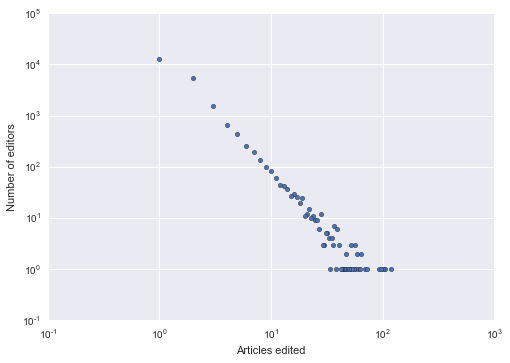

In [51]:
_s = (pd.Series(g_odc)*network_size)
_s = _s[_s>0]
ax = _s.value_counts().reset_index().plot(x='index',y=0,kind='scatter',logy=True,logx=True)
ax.set_ylabel('Number of editors')
ax.set_xlabel('Articles edited')

We can also compute the distribution of edge weights in the graph, which refers to the number of times an editor revised an article.

In [52]:
revision_edgelist['weight'].sort_values(ascending=False).head(10)

user             page                                                              
Wasted Time R    Hillary Clinton                                                       2357
Settler          Democratic Party (United States)                                       703
Ehlla            Endorsements for the Republican Party presidential primaries, 2016     700
LukeTH           Hillary Clinton                                                        656
Cwobeel          Carly Fiorina                                                          622
Ihardlythinkso   Donald Trump                                                           558
ObieGrad         United States presidential election, 2016                              548
                 United States presidential election debates, 2016                      548
Rjensen          Republican Party (United States)                                       530
Blondeguynative  Democratic Party (United States)                                       

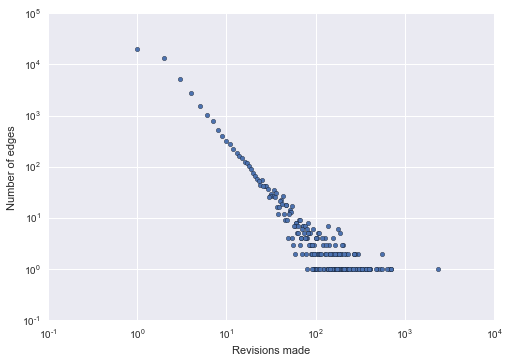

In [53]:
weights = revision_edgelist['weight']
ax = weights.value_counts().reset_index().plot(x='index',y='weight',kind='scatter',logy=True,logx=True)
ax.set_ylabel('Number of edges')
ax.set_xlabel('Revisions made')

What articles share the most editors in common?

In [54]:
article_clustering = nx.bipartite.latapy_clustering(election_g.to_undirected(),page_nodelist.index,'dot')
article_clustering_s = pd.Series(article_clustering).sort_values(ascending=False)
article_clustering_s.head(10)

Mike Huckabee presidential campaign, 2016                                  0.054858
Rick Santorum presidential campaign, 2016                                  0.050784
Carly Fiorina presidential campaign, 2016                                  0.050466
Jeb Bush presidential campaign, 2016                                       0.050252
Chris Christie presidential campaign, 2016                                 0.049923
Marco Rubio presidential campaign, 2016                                    0.048035
Ben Carson presidential campaign, 2016                                     0.047580
Ted Cruz presidential campaign, 2016                                       0.046901
Green Party presidential candidates, 2016                                  0.045939
United States third party and independent presidential candidates, 2016    0.045939
dtype: float64

# Get the hyperlinks from each article

The problem with the hyperlink parsing approach we used before was that many (probably all) the articles use the same template at the bottom --- which means this template makes all these articles link to each other. Plus each article has more templates that inflate the number of hyperlinks beyond what's in the text. If the hyperlinks in the text are what we're after, we're going to have to parse them out using code like we used to get the links from the first version of the Hillary Clinton article. Instead this time, we'll just pass the most recent version of the article (after checking to make sure the most recent version doesn't differ dramatically from the article's recent history).

The `idxmax` function applied to a groupby object is really powerful, it will tell you the index where the greatest value for a given variable occurs. In this case, we want the most recent revision, so passing `idxmax` to the max timestamp will return the index in the `multirevision_df` DataFrame where it occurs. THen we can just subset that DataFrame by those index values and return the relevant columns.

In [57]:
max_ix = multirevision_df.groupby(['page'])['timestamp'].idxmax()
most_recent_revids = multirevision_df.loc[max_ix,['page','revid']]
most_recent_revids.head()

,page,revid
230883,2016 Democratic National Convention,709778979
75333,2016 Green National Convention,709105441
169252,2016 Libertarian National Convention,709105349
144098,2016 Republican National Convention,710395488
210205,Alyson Kennedy,706554480


### Extracting links from parsed wiki-text

You don't need to screen-scrape or use regex to extract the links from a Wikipedia article. We'll use the API to get the parsed text back and then use the wonderful BeautifulSoup library to extract links from the page. We'll adapt the code from extracting links from the old Hillary Clinton article, but instead ask the API to return the parsed HTML of the page for a given revision of an article. We can pass this text to BeautifulSoup, we'll remove tags enclosing tables and divs that define the problematic template we want to ignore, and then extract all the links from the remaining main body of text.

Here we query the API to get the parsed HTML for the "Hillary Clinton" article and show the first 1000 characters of the string.

In [70]:
params = {'action': 'parse',
          'redirects':True,
          'prop': 'text',
          'page': 'Hillary Clinton'}

text = list(wt.api.APIRequest(wiki=enwp,data=params).queryGen())[0]['parse']['text']['*']
text[:1000]

u'<table class="infobox vcard" style="width:22em">\n<tr>\n<th colspan="2" style="text-align:center;font-size:125%;font-weight:bold;font-size: 130%;"><span class="fn">Hillary Rodham Clinton</span></th>\n</tr>\n<tr>\n<td colspan="2" style="text-align:center"><a href="/wiki/File:Hillary_Clinton_official_Secretary_of_State_portrait_crop.jpg" class="image"><img alt="Hillary Clinton official Secretary of State portrait crop.jpg" src="//upload.wikimedia.org/wikipedia/commons/thumb/2/27/Hillary_Clinton_official_Secretary_of_State_portrait_crop.jpg/220px-Hillary_Clinton_official_Secretary_of_State_portrait_crop.jpg" width="220" height="275" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/2/27/Hillary_Clinton_official_Secretary_of_State_portrait_crop.jpg/330px-Hillary_Clinton_official_Secretary_of_State_portrait_crop.jpg 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/2/27/Hillary_Clinton_official_Secretary_of_State_portrait_crop.jpg/440px-Hillary_Clinton_official_Secretary_of_State_

We can soup-ify this HTML string into a parseable object, remove content enclosed by tags we don't like that define tables and divs, then search the remaining content for links and extract them.

In [73]:
# Soup-ify the HTML string into a structured XML object
soup = BeautifulSoup(text,'lxml')

# Ignore links inside of tables and divs
for bad_tag in soup.find_all(['table','div']):
    bad_tag.extract()

# Create a container to hold the links we extract from the text
link_list = list()

# Find all the 'a' tags
for a in soup.find_all('a'):
    if 'wiki' in a['href']: # Make sure the link is to a wiki document
        try:
            link_list.append(a['title']) # Try to get the title
        except KeyError:
            pass # Otherwise skip

print "There are {0} links in the body of the Hillary Clinton article.".format(len(link_list))
link_list[:10]

There are 543 links in the body of the Hillary Clinton article.


['Help:IPA for English',
 'Hillary Clinton presidential campaign, 2016',
 '2016 Democratic National Convention',
 'President of the United States',
 'United States',
 'United States presidential election, 2016',
 'List of Secretaries of State of the United States',
 'United States Secretary of State',
 'United States Senate',
 'New York']

We'll create a function to automate this process.

In [69]:
def parse_links_from_article_text(revid):
    params = {'action': 'parse',
              'redirects':True,
              'prop': 'text',
              'oldid': '{0}'.format(revid)}
    text = list(wt.api.APIRequest(wiki=enwp,data=params).queryGen())[0]['parse']['text']['*']
    
    soup = BeautifulSoup(text,'lxml')
    
    for bad_tag in soup.find_all(['table','div']):
        bad_tag.extract()
    
    link_list = list()
    
    for a in soup.find_all('a'):
        if 'wiki' in a['href']: # Make sure the link is to a wiki document
            try:
                link_list.append(a['title']) # Try to get the title
            except KeyError:
                pass # Otherwise skip
    
    return link_list

Now go through each article's most recent revision, parse out the links using the function above, and store it in `article_outlinks_dict` where they keys are article names and the values are the lists of links on the most recent version of that article. This will take 3-5 minutes to pull all the data. Save it to JSON to avoid having to do it again.

I've commented that out so we don't accidentally run it. Instead, we'll just load from disk to save some time in the future.

In [60]:
with open('election_article_link_dict.json','rb') as f:
    article_link_dict = json.load(f)

### Make hyperlink network

We'll iterate over the `article_outlinks_dictionary` and construct a hyperlink network of how each seed article links to other concepts throughout Wikipedia.

In [61]:
election_hyperlink_g = nx.DiGraph()

for seed_article,outlink_list in article_link_dict.iteritems():
    if seed_article != 'Endorsements for the Republican Party presidential primaries, 2016':
        for outlink in outlink_list:
            if seed_article != outlink:
                if election_hyperlink_g.has_edge(seed_article,outlink):
                    election_hyperlink_g[seed_article][outlink]['weight'] += 1
                else:
                    election_hyperlink_g.add_edge(seed_article,outlink,weight=1)
        
print "There are {0} nodes and {1} edges in the network.".format(election_hyperlink_g.number_of_nodes(),election_hyperlink_g.number_of_edges())

nx.write_gexf(election_hyperlink_g,'election_hyperlink_g.gexf')

There are 9363 nodes and 17141 edges in the network.


What are the top nodes in the network?

In [62]:
# Network size to de-normalize network size
hyperlink_network_size = election_hyperlink_g.number_of_nodes() - 1

# In-degree centrality captures how many editors are on an article
hyperlink_g_idc = {k:v for k,v in nx.in_degree_centrality(election_hyperlink_g).iteritems()}

# Out-degree centrality captures how many articles users contributed to
hyperlink_g_odc = {k:v for k,v in nx.out_degree_centrality(election_hyperlink_g).iteritems()}

# Page-rank
hyperlink_pagerank = nx.pagerank(election_hyperlink_g)

The in-degree centrality captures the nodes that are pointed to the most by articles in the network.

In [63]:
(pd.Series(hyperlink_g_idc)*hyperlink_network_size).sort_values(ascending=False).head(10)

United States presidential election, 2016        94.0
President of the United States                   73.0
Republican Party (United States)                 57.0
Democratic Party (United States)                 48.0
Barack Obama                                     48.0
United States Senate                             47.0
United States presidential election, 2012        46.0
Wikipedia:Citation needed                        44.0
Donald Trump                                     43.0
Republican Party presidential primaries, 2016    42.0
dtype: float64

The out-degree centrality captures the nodes that point to the most other articles in the network.

In [64]:
(pd.Series(hyperlink_g_odc)*hyperlink_network_size).sort_values(ascending=False).head(10)

Democratic Party (United States)            628.0
Hillary Clinton                             513.0
Donald Trump                                485.0
Independent politician                      460.0
Political positions of Jeb Bush             397.0
Carly Fiorina                               358.0
Republican Party (United States)            351.0
Donald Trump presidential campaign, 2016    350.0
Bernie Sanders                              330.0
John Kasich                                 316.0
dtype: float64

The PageRank algorithm was an early version for recursively determining the influence of documents in an information network. A node has high PageRank centrality if it is referenced by other nodes with high PageRank centrality.

In [65]:
(pd.Series(hyperlink_pagerank)*hyperlink_network_size).sort_values(ascending=False).head(10)

United States presidential election, 2016        3.645051
President of the United States                   2.481603
Republican Party presidential primaries, 2016    2.030319
United States Senate                             1.887122
Democratic Party (United States)                 1.884065
Wikipedia:Citation needed                        1.874231
United States                                    1.833102
Democratic Party presidential primaries, 2016    1.769972
United States presidential election, 2012        1.767763
Donald Trump                                     1.731317
dtype: float64

Compute the betweenness centrality. A node has a high betweenness centrality lies along many shortest paths between other nodes. We're only going to be able to compute betweenness on a subset of the network since there are so many nodes in the network. We'll also account for the weight of the edges.

In [99]:
pd.Series(nx.betweenness_centrality_subset(election_hyperlink_g,
                                           page_nodelist.index,page_nodelist.index,
                                           weight='weight')).sort_values(ascending=False).head(10)

United States presidential election, 2016                                  9639.145621
United States presidential election, 2016 timeline                         1702.604717
Republican Party presidential candidates, 2016                             1289.291628
Donald Trump                                                               1187.171986
President of the United States                                             1085.033109
Democratic Party presidential primaries, 2016                               882.440373
Republican Party (United States)                                            845.401338
Democratic Party presidential candidates, 2016                              766.725819
Democratic Party (United States)                                            744.219652
United States third party and independent presidential candidates, 2016     671.097707
dtype: float64

One advantage of parsing the wiki-text is we can capture how many times an article links to another article. We captured this as an edge weight in the network above if the edge was already in the network by incrementing the edge weight up by one. Extract these edge weights and make it into a DataFrame and sort it by the edges that are repeated the most times.

In [66]:
edge_weight_df = pd.DataFrame([{'article_from':article1,'article_to':article2,'weight':d['weight']} for article1, article2, d in 
                              election_hyperlink_g.edges(data=True)])
edge_weight_df.sort_values('weight',ascending=False).head(20)

,article_from,article_to,weight
9116,Statewide opinion polling for the Democratic P...,Superdelegate,50
10375,Statewide opinion polling for the Republican P...,Donald Trump,19
1688,Democratic Party (United States),Barack Obama,11
16600,Mike Huckabee,John McCain,10
10513,Libertarian Party (United States),Wikipedia:Citation needed,10
16331,Ben Carson,International Standard Book Number,10
3611,Republican Party presidential debates and foru...,Donald Trump,8
1819,Democratic Party (United States),Bill Clinton,8
16685,Mike Huckabee,Mitt Romney,7
5478,Donald Trump,Trump Plaza Hotel and Casino,7


Compute the clustering over the set of seed nodes.

In [95]:
pd.Series(nx.clustering(election_hyperlink_g.to_undirected(),page_nodelist.index)).sort_values(ascending=False).head(10)

Nationwide opinion polling for the Democratic Party 2016 presidential primaries      0.621212
Endorsements for the Democratic Party presidential primaries, 2016                   0.527778
Nationwide opinion polling for the United States presidential election, 2016         0.500000
Nationwide opinion polling for the Republican Party 2016 presidential primaries      0.450980
Results of the Democratic Party presidential primaries, 2016                         0.428571
2016 Green National Convention                                                       0.428571
Political positions of the Democratic Party presidential primary candidates, 2016    0.333333
Rick Santorum presidential campaign, 2016                                            0.300000
Gary Johnson presidential campaign, 2016                                             0.257576
Lindsey Graham presidential campaign, 2016                                           0.246753
dtype: float64

Compute reciprocality. This actually isn't the "true" reciprocation fraction in the hyperlink graph, do you know why?

In [88]:
election_hyperlink_reciprocal_edges = list()
for (i,j) in election_hyperlink_g.edges():
    if election_hyperlink_g.has_edge(j,i) and (i,j) not in election_hyperlink_reciprocal_edges:
        election_hyperlink_reciprocal_edges.append((i,j))
        
reciprocation_fraction = round(float(len(election_hyperlink_reciprocal_edges))/election_hyperlink_g.number_of_edges(),3)
num_reciprocal_edges = len(election_hyperlink_reciprocal_edges)
edge_count = election_hyperlink_g.number_of_edges()

print "There are {0} reciprocated edges out of {1} edges in the network, giving a reciprocation fraction of {2:.1%}.".format(num_reciprocal_edges,edge_count,reciprocation_fraction)

There are 368 reciprocated edges out of 17141 edges in the network, giving a reciprocation fraction of 2.1%.
